# Import libraries

In [1]:
import os, os.path
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
import pandas as pd
import seaborn as sns
import numpy as np

# Specify filepaths

In [2]:
rhop30_path = 'data/20210729_edit/'
rhom30_path = 'data/20210923_edit/'
rhop37_path = 'data/20210802_edit/'
rhom37_path = 'data/20210921_edit/'
rhomYPG_path = 'data/20211001_edit/'
rhodamine_data = 'data/20230405_rhodamine_df.xlsx'
tecan384_data = 'data/20230418_tecan384wide.xlsx'
layout_path = 'data/20220517_mutant_plates_rearray.xlsx'
graph_outpath = 'graphs/'

# S & P data

## Functions

In [3]:
def annotate_df(df, plate_ID_path, layout_path):
    plateID_df = pd.read_excel(plate_ID_path, header=0)
    layout_df = pd.read_excel(layout_path, header=0)
    annot_plate_df = df.merge(right=plateID_df, on=['plate_number'])
    annot_layout_df = annot_plate_df.merge(right=layout_df, on=['rearray_plate_nb','RA_well'])
    return annot_layout_df

In [4]:
import glob
import math
from datetime import datetime

def pyphe_to_df(p, layout):
    
    list_of_plate_df = []

    for f in glob.glob(p + 'pyphe_quant/*.csv'):  
        plate_df = pd.read_csv(f, header=0, index_col=0)
    
        #For every picture in the folder, the file name is read and parsed ('_') to retrieve the plate number and timestamp
        plate_df['plate_number']=int(os.path.basename(f).split('_')[2])
        plate_df['timestamp'] = datetime.strptime('_'.join(os.path.basename(f).replace('.JPG.csv','').split('_')[3:]), '%y-%m-%d_%H-%M-%S')
        
        list_of_plate_df.append(plate_df)

    #Above we created one dataframe per plate, which we now concatenate into a single dataframe
    pic_df = pd.concat(list_of_plate_df, axis=0)
    
    #t0 is extracted by sorting by timestamp
    timestamps_list = pic_df['timestamp'].to_list()
    timestamps_list.sort()
    t0 = timestamps_list[0]
    
    #Timestamps are converted into time (s), then time (h)
    pic_df['time (s)'] = pic_df['timestamp'].apply(lambda x: (x - t0).total_seconds())
    pic_df['time (h)'] = round(pic_df['time (s)'] / 3600, 1)

    #This is useful if the plate has been expanded to feature 4 replicates per samples
    #'spot_well' would designate a single spot (= one replicate)
    #'RA_well' is short for 'rearray_well' and designates a sample on the original plate (before expansion)
    #For example B1 if I'm not mistaken, corresponds to the third replicate on a 384-array of sample in A1 on the corresponding 96-array pre-expansion
    pic_df['spot_well'] = pic_df.apply(lambda row: chr(64 + row.row) + str(row.column), axis=1)
    pic_df['RA_well'] = pic_df.apply(lambda row: chr(64 + math.ceil(row.row / 2)) + str(math.ceil(row.column / 2)), axis=1)

    pic_df = pic_df.sort_values(by=['plate_number','time (h)'])
    
    #Annotate dataframe
    annot_layout_df = annotate_df(pic_df, p+p[5:-6]+'_plates_identity.xlsx', layout)

    return annot_layout_df

In [5]:
def get_robot_auc(g):
    return np.trapz(g.area)

In [6]:
def get_normalized_value(df, pn, strain, well):
    control = df.loc[(df['genotype']=='wt') & (df['plate_number']==pn) & (df['strain']==strain), 'auc'].values[0]
    val = df.loc[(df['plate_number']==pn) & (df['RA_well']==well), 'auc'].values[0]
    return val/control

In [7]:
def generate_relative_fitness(path, incubation_time, layout):
    df = pyphe_to_df(path, layout)
    aucdf = df[df['time (h)'] <= incubation_time].groupby(['plate_number','RA_well','spot_well'])[['area']].apply(func=get_robot_auc).reset_index(name='auc')
    meandf = aucdf.groupby(['plate_number','RA_well'])[['auc']].mean().reset_index()
    rho_df = annotate_df(meandf, path+path[5:-6]+'_plates_identity.xlsx', layout)
    rho_df['rel_fit'] = rho_df.apply(lambda row: get_normalized_value(rho_df, row.plate_number, row.strain, row.RA_well), axis=1)
    return rho_df

In [8]:
def get_Spearman(df, strain_name, rho_status, condition1, condition2):
    
    from scipy import stats
    
    fit1 = df[(df.strain==strain_name) & (df.respiration==rho_status)][condition1].values
    fit2 = df[(df.strain==strain_name) & (df.respiration==rho_status)][condition2].values
    
    return stats.spearmanr(fit1, fit2)

## Rho+ 37°C

In [22]:
rhop_df = generate_relative_fitness(rhop37_path, incubation_time = 22, layout = layout_path)
rhop_df

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit
0,1,B10,19964.125,1,YPD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113.0,1.0,A11,0.926485
1,2,B10,13022.375,1,SD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113.0,1.0,A11,0.993439
2,3,B10,18286.875,1,5-FC,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113.0,1.0,A11,2.226848
3,4,B10,7054.500,1,Mica_low,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113.0,1.0,A11,0.822359
4,5,B10,4436.375,1,Mica_mid,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113.0,1.0,A11,0.852268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4615,11,O9,2543.125,1,Nystatin_mid,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112.0,1.0,D10,0.795161
4616,12,O9,2168.625,1,Nystatin_high,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112.0,1.0,D10,0.857037
4617,13,O9,7997.375,1,Fluco_low,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112.0,1.0,D10,0.748249
4618,14,O9,6127.375,1,Fluco_mid,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112.0,1.0,D10,0.766149


In [23]:
rhop_df.to_excel('data/rhop37_22h.xlsx')

## Rho- 37°C

In [24]:
rhom_df = generate_relative_fitness(rhom37_path, incubation_time = 22, layout = layout_path)
rhom_df

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit
0,1,B10,10944.250,2,YPD,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49.0,NaN,NaN,0.465901
1,2,B10,7147.125,2,SD,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49.0,NaN,NaN,0.636828
2,3,B10,9443.375,2,5-FC,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49.0,NaN,NaN,2.459532
3,4,B10,11702.500,2,5-FU,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49.0,NaN,NaN,2.244277
4,5,B10,6108.500,2,Fluco_low,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49.0,NaN,NaN,0.845233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,29,G9,5166.875,3,Caspo_high,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48.0,NaN,NaN,1.147493
1901,30,G9,9393.625,3,Mica_low,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48.0,NaN,NaN,1.099361
1902,31,G9,5692.625,3,Mica_mid,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48.0,NaN,NaN,0.899664
1903,32,G9,4455.250,3,Mica_high,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48.0,NaN,NaN,0.996951


In [25]:
# Filtering out misannotated rho+ mutants from rho- plates
rhom_df.drop(rhom_df[(rhom_df.genotype=='mutant') & (rhom_df.respiration==True)].index, inplace=True)

In [26]:
rhom_df.to_excel('data/rhom37_22h.xlsx')

In [27]:
rhom_df = pd.read_excel('data/rhom37_22h.xlsx', index_col=0)
rhom_df

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit
0,1,B10,10944.250,2,YPD,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49,NaN,NaN,0.465901
1,2,B10,7147.125,2,SD,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49,NaN,NaN,0.636828
2,3,B10,9443.375,2,5-FC,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49,NaN,NaN,2.459532
3,4,B10,11702.500,2,5-FU,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49,NaN,NaN,2.244277
4,5,B10,6108.500,2,Fluco_low,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49,NaN,NaN,0.845233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,29,G9,5166.875,3,Caspo_high,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48,NaN,NaN,1.147493
1901,30,G9,9393.625,3,Mica_low,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48,NaN,NaN,1.099361
1902,31,G9,5692.625,3,Mica_mid,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48,NaN,NaN,0.899664
1903,32,G9,4455.250,3,Mica_high,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48,NaN,NaN,0.996951


In [28]:
# Importing rhodamine data
selrhom37_df = rhom_df[rhom_df.condition.isin(['YPD','SD','5-FC','Mica_high','Caspo_high','Nystatin_high','Fluco_high'])]
widerhom37_df = selrhom37_df.pivot(index=['rearray_plate_nb','RA_well','strain','fluc_assay','pre_culture','genotype','respiration'],columns='condition', values='rel_fit').reset_index()
rhod_df = pd.read_excel(rhodamine_data, header=0, index_col=0)
widerhom37_df = widerhom37_df.merge(right=rhod_df, on=['rearray_plate_nb','strain','RA_well'])
widerhom37_df

,rearray_plate_nb,RA_well,strain,fluc_assay,pre_culture,genotype,respiration,5-FC,Caspo_high,Fluco_high,Mica_high,Nystatin_high,SD,YPD,type,well,perc_pos,perc_norm
0,2,B10,LL13-040,7.0,3.0,mutant,False,2.459532,0.490954,1.221070,1.526173,0.346933,0.636828,0.465901,rho0,B10,7.40,0.632479
1,2,B11,LL13-040,7.0,3.0,mutant,False,1.932511,0.112269,0.939837,1.223133,0.142565,0.594282,0.410868,rho0,B11,9.25,0.790598
2,2,B2,LL13-040,1.0,1.0,mutant,False,0.805020,0.147903,0.437949,0.591763,0.215291,0.261539,0.475016,rho0,B02,6.05,0.517094
3,2,B3,LL13-040,3.0,3.0,mutant,False,2.646666,0.285013,1.006576,1.716826,0.408580,0.630558,0.564787,rho0,B03,6.60,0.564103
4,2,B4,LL13-040,4.0,2.0,mutant,False,3.071559,0.517232,1.231443,1.939455,0.661468,0.610643,0.559545,rho0,B04,8.75,0.747863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,3,G5,NC-02,4.0,2.0,mutant,False,1.885240,0.857420,1.648419,1.065928,0.864654,0.881574,0.798866,rho0,G05,6.15,0.280182
111,3,G6,NC-02,4.0,1.0,mutant,False,1.713849,0.928266,1.793975,1.095242,0.964798,0.936484,0.788152,rho0,G06,6.00,0.273349
112,3,G7,NC-02,4.0,1.0,mutant,False,1.542052,1.076231,1.807980,0.963414,1.025095,0.841602,0.834562,rho0,G07,6.15,0.280182
113,3,G8,NC-02,4.0,4.0,mutant,False,1.907561,0.731525,1.804633,1.177198,0.968706,0.889176,0.793636,rho0,G08,3.95,0.179954


In [29]:
widerhom37_df.to_excel('data/widerhom37_22h.xlsx')

## Pooling rho+ and rho- 37°C

In [3]:
rhop_df = pd.read_excel('data/rhop37_22h.xlsx', header=0, index_col=0)
rhom_df = pd.read_excel('data/rhom37_22h.xlsx', header=0, index_col=0)

In [4]:
missing_conditions = [x for x in max(rhop_df.condition.unique().tolist(),rhom_df.condition.unique().tolist(), key=len) if x not in min(rhop_df.condition.unique().tolist(),rhom_df.condition.unique().tolist(), key=len)]
print("Conditions missing in one of the dataframes:", missing_conditions)

Conditions missing in one of the dataframes: ['5-FU']


In [6]:
pool37_df = pd.concat([rhop_df, rhom_df])
pool37_df

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit
0,1,B10,19964.125,1,YPD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.926485
1,2,B10,13022.375,1,SD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.993439
2,3,B10,18286.875,1,5-FC,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,2.226848
3,4,B10,7054.500,1,Mica_low,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.822359
4,5,B10,4436.375,1,Mica_mid,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.852268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1900,29,G9,5166.875,3,Caspo_high,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48,NaN,NaN,1.147493
1901,30,G9,9393.625,3,Mica_low,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48,NaN,NaN,1.099361
1902,31,G9,5692.625,3,Mica_mid,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48,NaN,NaN,0.899664
1903,32,G9,4455.250,3,Mica_high,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48,NaN,NaN,0.996951


In [13]:
gby37 = pool37_df.groupby(['strain','condition'])[['auc','rel_fit']].mean().reset_index()
gby37[(~gby37.condition.isin(['YPD', 'SD', '5-FC', '5-FU']))]

,strain,condition,auc,rel_fit
2,LL13-040,Caspo_high,3633.030878,0.819523
3,LL13-040,Caspo_low,7912.038504,0.841839
4,LL13-040,Caspo_mid,4398.615513,0.817245
5,LL13-040,Fluco_high,6864.108259,1.004135
6,LL13-040,Fluco_low,8487.426339,0.866589
7,LL13-040,Fluco_mid,6687.703125,0.908459
8,LL13-040,Mica_high,3469.802455,1.057932
9,LL13-040,Mica_low,6299.497396,0.927621
10,LL13-040,Mica_mid,4278.814918,1.187795
11,LL13-040,Nystatin_high,2054.582775,0.822450


In [14]:
sel37_df = pool37_df[pool37_df.condition.isin(['YPD','SD','5-FC','Mica_low','Caspo_low','Nystatin_low','Fluco_high'])]
wide37_df = sel37_df.pivot(index=['rearray_plate_nb','RA_well','strain','fluc_assay','pre_culture','genotype','respiration'],columns='condition', values='rel_fit').reset_index()
wide37_df

condition,rearray_plate_nb,RA_well,strain,fluc_assay,pre_culture,genotype,respiration,5-FC,Caspo_low,Fluco_high,Mica_low,Nystatin_low,SD,YPD
0,1,B10,LL13-040,5.0,3.0,mutant,True,2.226848,0.925959,0.938230,0.822359,1.031657,0.993439,0.926485
1,1,B11,LL13-040,5.0,4.0,mutant,True,1.891424,0.933826,0.859766,0.847902,0.875719,0.909714,0.911814
2,1,B12,LL13-040,6.0,3.0,mutant,True,1.847464,0.953826,0.908647,0.865549,0.946033,0.896583,0.881957
3,1,B13,LL13-040,6.0,5.0,mutant,True,1.935734,0.922960,1.001824,0.922815,0.930109,0.941059,0.914813
4,1,B14,NC-02,2.0,1.0,mutant,True,2.330562,0.964526,1.037661,1.111597,0.940065,1.023869,0.941790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,3,G5,NC-02,4.0,2.0,mutant,False,1.885240,0.808299,1.648419,0.892301,0.932186,0.881574,0.798866
419,3,G6,NC-02,4.0,1.0,mutant,False,1.713849,0.824582,1.793975,1.037172,1.008687,0.936484,0.788152
420,3,G7,NC-02,4.0,1.0,mutant,False,1.542052,0.819145,1.807980,1.030458,0.884778,0.841602,0.834562
421,3,G8,NC-02,4.0,4.0,mutant,False,1.907561,0.971211,1.804633,0.982474,0.961764,0.889176,0.793636


## Rho+ 30°C

In [27]:
rhop_df = generate_relative_fitness(rhop30_path, incubation_time = 22, layout = layout_path)
rhop_df

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit
0,1,B10,14701.125,1,YPD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113.0,1.0,A11,0.974173
1,2,B10,10836.625,1,SD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113.0,1.0,A11,0.958061
2,3,B10,13931.625,1,5-FC,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113.0,1.0,A11,1.954321
3,4,B10,9752.000,1,5-FU_high,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113.0,1.0,A11,1.870618
4,5,B10,11265.875,1,5-FU_low,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113.0,1.0,A11,1.602913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1535,1,O9,13071.000,1,YPD,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112.0,1.0,D10,0.866153
1536,2,O9,10250.375,1,SD,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112.0,1.0,D10,0.906231
1537,3,O9,11339.000,1,5-FC,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112.0,1.0,D10,1.590629
1538,4,O9,7949.875,1,5-FU_high,5,B2,LL13-040,5.0,2.0,2.0,mutant,NaN,NaN,True,112.0,1.0,D10,1.524936


In [28]:
# Dropping 5-FU_low condition
rhop_df.drop(rhop_df[rhop_df.condition=='5-FU_low'].index, inplace=True)
rhop_df.replace('5-FU_high','5-FU', inplace=True)

In [29]:
rhop_df.to_excel('data/rhop30.xlsx')

## Rho- 30°C

In [30]:
rhom_df = generate_relative_fitness(rhom30_path, incubation_time = 22, layout = layout_path)
rhom_df

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit
0,1,B10,11451.750,2,YPD,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49.0,NaN,NaN,0.625057
1,2,B10,5914.875,2,SD,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49.0,NaN,NaN,0.620357
2,3,B10,7893.375,2,5-FC,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49.0,NaN,NaN,1.619278
3,4,B10,8580.250,2,5-FU,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49.0,NaN,NaN,1.518561
4,1,B11,8665.750,2,YPD,7,E4,LL13-040,7.0,3.0,11.0,mutant,NaN,NaN,False,55.0,NaN,NaN,0.472992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8,G8,8472.875,3,5-FU,3,H10,NC-02,4.0,4.0,2.0,mutant,NaN,NaN,False,42.0,NaN,NaN,1.830242
472,5,G9,13367.500,3,YPD,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48.0,NaN,NaN,0.817153
473,6,G9,9779.125,3,SD,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48.0,NaN,NaN,1.000281
474,7,G9,7290.625,3,5-FC,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48.0,NaN,NaN,1.987765


In [31]:
# Filtering out misannotated rho+ mutants from rho- plates
rhom_df.drop(rhom_df[(rhom_df.genotype=='mutant') & (rhom_df.respiration==True)].index, inplace=True)

In [32]:
rhom_df.to_excel('data/rhom30.xlsx')

## Pooling rho+ and rho- 30°C

In [9]:
rhop_df = pd.read_excel('data/rhop30.xlsx', header=0, index_col=0)
rhom_df = pd.read_excel('data/rhom30.xlsx', header=0, index_col=0)

In [10]:
missing_conditions = [x for x in max(rhop_df.condition.unique().tolist(),rhom_df.condition.unique().tolist(), key=len) if x not in min(rhop_df.condition.unique().tolist(),rhom_df.condition.unique().tolist(), key=len)]
print("Conditions missing in one of the dataframes:", missing_conditions)

Conditions missing in one of the dataframes: []


In [11]:
pool30_df = pd.concat([rhop_df, rhom_df])
pool30_df

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit
0,1,B10,14701.125,1,YPD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.974173
1,2,B10,10836.625,1,SD,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,0.958061
2,3,B10,13931.625,1,5-FC,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,1.954321
3,4,B10,9752.000,1,5-FU,5,A3,LL13-040,5.0,3.0,2.0,mutant,NaN,NaN,True,113,1.0,A11,1.870618
5,1,B11,12602.375,1,YPD,5,E5,LL13-040,5.0,4.0,12.0,mutant,NaN,NaN,True,127,2.0,A7,0.835099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
471,8,G8,8472.875,3,5-FU,3,H10,NC-02,4.0,4.0,2.0,mutant,NaN,NaN,False,42,NaN,NaN,1.830242
472,5,G9,13367.500,3,YPD,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48,NaN,NaN,0.817153
473,6,G9,9779.125,3,SD,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48,NaN,NaN,1.000281
474,7,G9,7290.625,3,5-FC,4,A8,NC-02,5.0,3.0,7.0,mutant,NaN,NaN,False,48,NaN,NaN,1.987765


In [12]:
sel30_df = pool30_df[pool30_df.condition.isin(['YPD','SD','5-FC','5-FU','Mica_low','Caspo_low','Nystatin_low','Fluco_high'])]
wide30_df = sel30_df.pivot(index=['rearray_plate_nb','RA_well','strain','fluc_assay','pre_culture','genotype','respiration'],columns='condition', values='rel_fit').reset_index()
wide30_df

condition,rearray_plate_nb,RA_well,strain,fluc_assay,pre_culture,genotype,respiration,5-FC,5-FU,SD,YPD
0,1,B10,LL13-040,5.0,3.0,mutant,True,1.954321,1.870618,0.958061,0.974173
1,1,B11,LL13-040,5.0,4.0,mutant,True,1.673482,1.542248,0.829005,0.835099
2,1,B12,LL13-040,6.0,3.0,mutant,True,1.682267,1.625977,0.964426,0.882454
3,1,B13,LL13-040,6.0,5.0,mutant,True,1.777464,1.735410,0.914298,0.920457
4,1,B14,NC-02,2.0,1.0,mutant,True,2.067802,1.880870,1.032883,0.924059
...,...,...,...,...,...,...,...,...,...,...,...
418,3,G5,NC-02,4.0,2.0,mutant,False,2.108173,1.455434,0.835816,0.763091
419,3,G6,NC-02,4.0,1.0,mutant,False,1.961659,1.743459,0.843219,0.691845
420,3,G7,NC-02,4.0,1.0,mutant,False,1.970725,1.562927,0.939254,0.825092
421,3,G8,NC-02,4.0,4.0,mutant,False,2.322473,1.830242,0.877281,0.681720


In [13]:
tecan384df = pd.read_excel(tecan384_data, index_col=0)
wide_sol_liq = wide30_df.merge(right=tecan384df, on=['rearray_plate_nb','RA_well','strain','genotype','respiration'])
wide_sol_liq

,rearray_plate_nb,RA_well,strain,fluc_assay,pre_culture,genotype,respiration,5-FC,5-FU,SD,YPD,5-FC_liq,SD_liq
0,1,B14,NC-02,2.0,1.0,mutant,True,2.067802,1.880870,1.032883,0.924059,2.757345,1.269227
1,1,B15,NC-02,3.0,2.0,mutant,True,2.114228,1.966782,1.168387,0.934091,2.806210,1.096943
2,1,B2,LL13-040,1.0,1.0,mutant,True,1.576461,1.649475,0.833138,0.928525,2.866106,1.279732
3,1,B3,LL13-040,3.0,1.0,mutant,True,1.599975,1.633146,0.855064,0.903501,2.683896,1.283241
4,1,B4,LL13-040,3.0,3.0,mutant,True,1.591699,1.623411,0.891466,0.905299,2.715165,1.475373
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,3,E3,NC-02,2.0,1.0,mutant,False,2.091098,2.073903,0.812558,0.807785,0.816232,0.508661
91,3,F2,NC-02,3.0,1.0,mutant,False,2.249370,1.682382,1.000115,0.819896,1.118174,0.616176
92,3,F3,NC-02,3.0,1.0,mutant,False,2.368550,1.845606,1.143369,0.837899,0.907390,0.547253
93,3,G2,NC-02,3.0,3.0,mutant,False,1.813373,1.406831,0.624171,0.624288,1.292205,0.844786


In [14]:
wide_sol_liq[wide_sol_liq.genotype!='mutant']

,rearray_plate_nb,RA_well,strain,fluc_assay,pre_culture,genotype,respiration,5-FC,5-FU,SD,YPD,5-FC_liq,SD_liq
18,1,E23,NC-02,NaN,NaN,wt,True,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
24,1,F23,NC-02,NaN,NaN,FCY1,True,1.176065,0.878850,1.061738,0.928241,2.965905,1.153566
37,1,I13,LL13-040,NaN,NaN,FCY1,True,1.205825,0.991344,1.039099,0.994243,2.179410,0.969056
82,2,G11,LL13-040,NaN,NaN,wt,True,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Rho- YPG

In [9]:
rhomYPG = generate_relative_fitness(rhomYPG_path, incubation_time = 22, layout = layout_path)
rhomYPG

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit
0,1,B10,2011.875000,2,YPG,7,D3,LL13-040,7.0,3.0,2.0,mutant,NaN,NaN,False,49.0,NaN,NaN,0.340239
1,1,B11,2150.500000,2,YPG,7,E4,LL13-040,7.0,3.0,11.0,mutant,NaN,NaN,False,55.0,NaN,NaN,0.363682
2,1,B2,1263.833333,2,YPG,1,B1,LL13-040,1.0,1.0,3.0,mutant,wt,NaN,False,1.0,NaN,NaN,0.213734
3,1,B3,1495.666667,2,YPG,2,B1,LL13-040,3.0,3.0,22.0,mutant,NaN,NaN,False,7.0,NaN,NaN,0.252940
4,1,B4,2462.375000,2,YPG,2,E8,LL13-040,4.0,2.0,16.0,mutant,NaN,NaN,False,13.0,NaN,NaN,0.416425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,2,G5,3069.375000,3,YPG,3,C7,NC-02,4.0,2.0,19.0,mutant,NaN,NaN,False,24.0,NaN,NaN,0.377595
114,2,G6,3127.500000,3,YPG,3,E4,NC-02,4.0,1.0,18.0,mutant,NaN,NaN,False,30.0,NaN,NaN,0.384746
115,2,G7,3348.125000,3,YPG,3,F3,NC-02,4.0,1.0,11.0,mutant,NaN,NaN,False,36.0,NaN,NaN,0.411887
116,2,G8,3193.500000,3,YPG,3,H10,NC-02,4.0,4.0,2.0,mutant,NaN,NaN,False,42.0,NaN,NaN,0.392865


## Scatterplots 37°C

### Two-way ANOVA with Tukey's multiple comparison test

In [15]:
from flucytosine_functions import get_Tukey
get_Tukey(sel37_df[(sel37_df.genotype.isin(['wt','mutant'])) & (sel37_df.strain=='NC-02')], 'respiration', 'condition', 'rel_fit')[1]

C:\Users\duran\OneDrive - Université Laval\Notebooks\ASUS_notebooks\Durand_et_al_2023\flucytosine_functions.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anova_df['combination'] = anova_df.apply(lambda row: str(row[factor1])+' / '+str(row[factor2]), axis=1)


,condition1,group1,group2,p-adj,reject,stat_significance
6,5-FC,False / 5-FC,True / 5-FC,1.0000,False,ns
19,Caspo_low,False / Caspo_low,True / Caspo_low,1.0000,False,ns
31,Fluco_high,False / Fluco_high,True / Fluco_high,0.0000,True,****
42,Mica_low,False / Mica_low,True / Mica_low,0.0007,True,***
52,Nystatin_low,False / Nystatin_low,True / Nystatin_low,0.0287,True,*
61,SD,False / SD,True / SD,1.0000,False,ns
69,YPD,False / YPD,True / YPD,0.0000,True,****


C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
C:\Users\duran\OneDrive - Université Laval\Notebooks\ASUS_notebooks\Durand_et_al_2023\flucytosine_functions.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anova_df['combination'] = anova_df.apply(lambda row: str(row[factor1])+' / '+str(row[factor2]), axis=1)

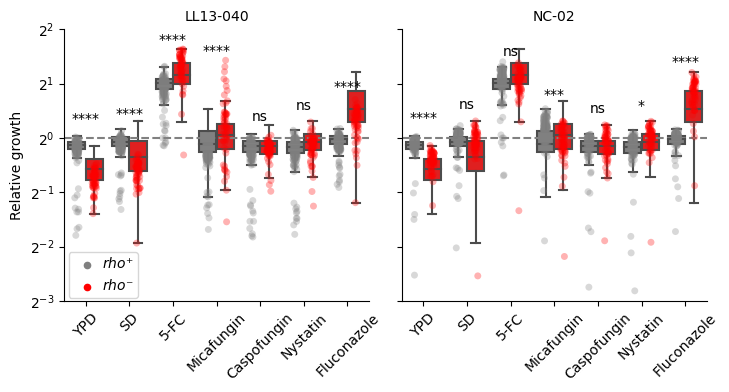

In [16]:
# V1 with lowest concentration of drugs for caspo-mica-nystatin and medium for fluconazole
fig = sns.catplot(data=sel37_df[sel37_df.genotype.isin(['wt','mutant'])],
                  col='strain', col_order=['LL13-040','NC-02'],
                  x='condition', y='rel_fit',
                  hue='respiration', hue_order=[True, False], palette=['grey','red'], alpha=.3,
                  kind='strip', dodge=True, legend_out=False,
                  height=4.02, aspect=0.93 # height*aspect = width of EACH facet
                 )

fig.map(sns.boxplot,
        data=sel37_df[sel37_df.genotype.isin(['wt','mutant'])],
        x='condition', y='rel_fit',
        hue='respiration', hue_order=[True, False], palette=['grey','red'],
        fliersize=0
       )

fig.map(plt.axhline, y=1, ls='--', c='grey')
plt.yscale('log',base=2)
fig.set(ylim=(2**-3,2**2))
fig.set_xticklabels(['YPD','SD','5-FC','Micafungin','Caspofungin','Nystatin','Fluconazole'], rotation=45)
fig.set_axis_labels('', 'Relative growth')
fig.set_titles(col_template='{col_name}')

handles, labels = fig.axes[0][1].get_legend_handles_labels()
sns.move_legend(fig, bbox_to_anchor=(0.08, 0.23), loc='lower left', title=None, frameon=True,
                handles=handles, labels=['$\it{rho}$⁺','$\it{rho}$⁻'], markerscale=0.75,
                handletextpad=0.1, borderpad=0.3)

# Because move_legend function does not accept formatted labels, we need to set them manually
#for i, v in enumerate():
#    fig._legend.texts[i].set_text(v)

for i, s in enumerate(sel37_df.strain.unique()):
    for j, x in enumerate(sel37_df.condition.unique()):
        maxv = sel37_df[(sel37_df.genotype.isin(['wt','mutant'])) & (sel37_df.strain==s) & (sel37_df.condition==x)].rel_fit.max()
        tukey_df = get_Tukey(sel37_df[(sel37_df.genotype.isin(['wt','mutant'])) & (sel37_df.strain==s)], 'respiration','condition','rel_fit')[1]
        tukey_stat = tukey_df.loc[tukey_df.condition1==x, 'stat_significance'].values[0]
        fig.axes[0][i].text(j, maxv+0.2, tukey_stat, ha='center')

#fig.fig.subplots_adjust(top=0.92)
#fig.fig.suptitle('Relative fitness at 37°C')
fig.tight_layout()
plt.savefig(graph_outpath+'20230724_rel_fit_pooled_respi_37_22h_stats.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'20230724_rel_fit_pooled_respi_37_22h_stats.png', format='png', dpi=300)

C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


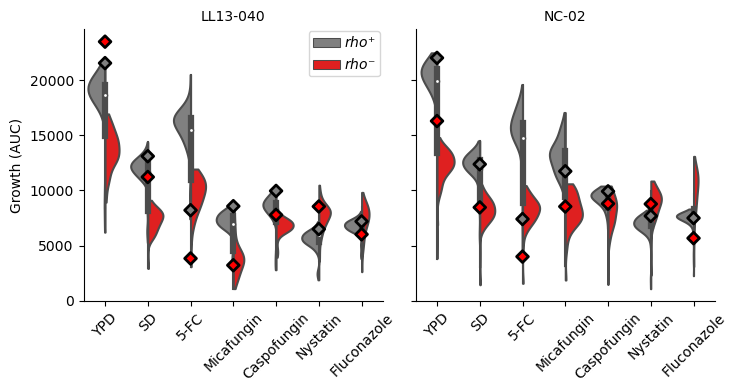

In [17]:
fig = sns.catplot(data=sel37_df[sel37_df.genotype == 'mutant'],
                  col='strain', col_order=['LL13-040','NC-02'],
                  x='condition', y='auc',
                  hue='respiration', hue_order=[True, False], palette=['grey','red'], alpha=.5,
                  kind='violin', cut=0, split=True, legend_out=False,
                  height=4.02, aspect=0.93 # height*aspect = width of EACH facet
                 )

cdic = {1: 'grey', 2: 'red', 3: 'red'}
for i, s in enumerate(sel37_df.strain.unique()):
    fig.axes[0][i].scatter(data=sel37_df[(sel37_df.genotype == 'wt') & (sel37_df.strain == s)],
                           x='condition', y='auc',
                           c=sel37_df[(sel37_df.genotype == 'wt') & (sel37_df.strain == s)].rearray_plate_nb.map(cdic),
                           marker='D', zorder=1000, edgecolor='black', linewidth=2
                          )

fig.set(xlim=(-0.5, len(sel37_df.condition.unique())-0.5))
fig.set_xticklabels(['YPD','SD','5-FC','Micafungin','Caspofungin','Nystatin','Fluconazole'], rotation=45)
fig.set_axis_labels('', 'Growth (AUC)')
fig.set_titles(col_template='{col_name}')

handles, labels = fig.axes[0][1].get_legend_handles_labels()
sns.move_legend(fig, bbox_to_anchor=(0.41, 0.78), loc='lower left', title=None, frameon=True,
                handles=handles, labels=['$\it{rho}$⁺','$\it{rho}$⁻'], markerscale=0.75,
                handletextpad=0.25, borderpad=0.3)

fig.tight_layout()
plt.savefig(graph_outpath+'20230724_AUC_pooled_respi_37_22h_stats.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'20230724_AUC_pooled_respi_37_22h_stats.png', format='png', dpi=300)

## Rhodamine plots

In [34]:
percdf = pd.read_excel(rhodamine_data, header=0, index_col=0)
percdf

,rearray_plate_nb,strain,type,well,perc_pos,RA_well,perc_norm
0,2,LL13-040,negative_control,A02,1.05,NaN,0.089744
1,2,LL13-040,positive_control,A01,97.50,NaN,8.333333
2,2,LL13-040,rho0,B02,6.05,B2,0.517094
3,2,LL13-040,rho0,B03,6.60,B3,0.564103
4,2,LL13-040,rho0,B04,8.75,B4,0.747863
...,...,...,...,...,...,...,...
118,3,NC-02,rho0,G08,3.95,G8,0.179954
119,3,NC-02,rho0,G09,8.05,G9,0.366743
120,3,NC-02,rho0,G10,7.10,G10,0.323462
121,3,NC-02,rho_plus,D08,16.00,D8,0.728929


### Relative % rhodamine accumulation

This version of the figure has not been kept in the final version of the manuscript

In [21]:
Lbaseline = percdf.loc[(percdf.strain=='LL13-040') & (percdf.type=='negative_control'), 'perc_norm'].values[0]
Nbaseline = percdf.loc[(percdf.strain=='NC-02') & (percdf.type=='negative_control'), 'perc_norm'].values[0]
Lpos = percdf.loc[(percdf.strain=='LL13-040') & (percdf.type=='positive_control'), 'perc_norm'].values[0]
Npos = percdf.loc[(percdf.strain=='NC-02') & (percdf.type=='positive_control'), 'perc_norm'].values[0]

/home/rodur28/anaconda3/lib/python3.8/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


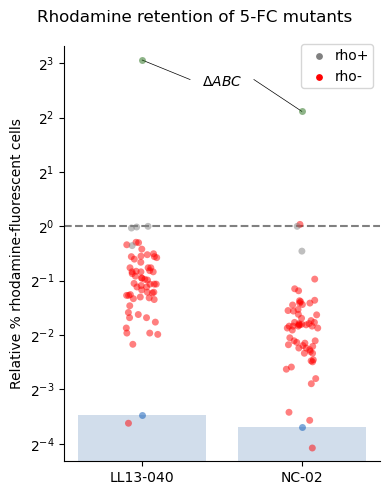

In [22]:
from matplotlib.patches import Rectangle

f, ax = plt.subplots(figsize=(4, 5))
fig = sns.stripplot(data=percdf[percdf.type.isin(['wt','rho_plus','rho0'])], x='strain', y='perc_norm', hue='type', hue_order=['wt','rho_plus','rho0'], palette=['grey','grey','red'], alpha=.5)
sns.stripplot(data=percdf[percdf.type=='positive_control'], x='strain', y='perc_norm', color='#1e6a12', alpha=.5, jitter=False)
sns.stripplot(data=percdf[percdf.type=='negative_control'], x='strain', y='perc_norm', color='#0555b5', alpha=.5, jitter=False)
sns.barplot(data=percdf[percdf.type=='negative_control'], x='strain', y='perc_norm', color='#0555b5', alpha=.2) # display detection threshold

plt.yscale('log', base=2)
fig.set(ylim=(0.05,10))
fig.axes.axhline(y=1, ls='--', c='grey')

handles, labels = fig.get_legend_handles_labels()
handles_rho = handles[-2:]
sns.move_legend(fig, bbox_to_anchor=(1, 1.02), loc='upper right', title=None, frameon=True, handles=handles_rho, labels=['rho+','rho-'], markerscale=0.5, handletextpad=0.1, borderpad=0.3)

ax.text(0.5, 6, u'Δ$\itABC$', horizontalalignment='center')
plt.plot([0, 0.3], [Lpos, 6.5], color='k', linestyle='-', linewidth=0.5, zorder=0)
plt.plot([0.7, 1], [6.5, Npos], color='k', linestyle='-', linewidth=0.5, zorder=0)

fig.axes.set(xlabel='', ylabel='Relative % rhodamine-fluorescent cells')
plt.suptitle('Rhodamine retention of 5-FC mutants')
plt.tight_layout()
sns.despine()
plt.savefig(graph_outpath+'20221201_rhodamine_retention_normalized.png', format='png', dpi=300)
plt.savefig(graph_outpath+'20221201_rhodamine_retention_normalized.svg', format='svg', dpi=300)

### % rhodamine accumulation

In [35]:
Lpos = percdf.loc[(percdf.strain=='LL13-040') & (percdf.type=='positive_control'), 'perc_pos'].values[0]
Npos = percdf.loc[(percdf.strain=='NC-02') & (percdf.type=='positive_control'), 'perc_pos'].values[0]
Lwt = percdf.loc[(percdf.strain=='LL13-040') & (percdf.type=='wt'), 'perc_pos'].values[0]
Nwt = percdf.loc[(percdf.strain=='NC-02') & (percdf.type=='wt'), 'perc_pos'].values[0]

C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


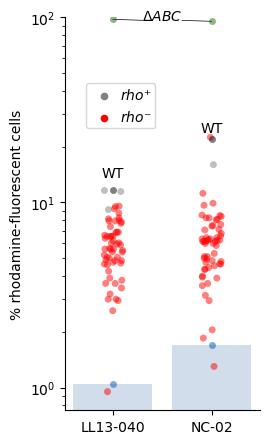

In [41]:
from matplotlib.patches import Rectangle

f, ax = plt.subplots(figsize=(2.8, 4.55))
fig = sns.stripplot(data=percdf[percdf.type.isin(['rho_plus','rho0'])], x='strain', y='perc_pos', hue='type', hue_order=['rho_plus','rho0'], palette=['grey','red'], alpha=.5)
sns.stripplot(data=percdf[percdf.type=='wt'], x='strain', y='perc_pos', color='black', alpha=.5, jitter=False)
sns.stripplot(data=percdf[percdf.type=='positive_control'], x='strain', y='perc_pos', color='#1e6a12', alpha=.5, jitter=False)
sns.stripplot(data=percdf[percdf.type=='negative_control'], x='strain', y='perc_pos', color='#0555b5', alpha=.5, jitter=False)
sns.barplot(data=percdf[percdf.type=='negative_control'], x='strain', y='perc_pos', color='#0555b5', alpha=.2) # display detection threshold

plt.yscale('log', base=10)
fig.set(ylim=(None,100))

handles, labels = fig.get_legend_handles_labels()
handles_rho = handles[-2:]
sns.move_legend(fig, bbox_to_anchor=(0.5, 0.85), loc='upper right', title=None, frameon=True, handles=handles_rho, labels=['$\it{rho}$⁺','$\it{rho}$⁻'], markerscale=0.75, handletextpad=0.1, borderpad=0.3)

ax.text(0.5, (Lpos+Npos)/2, u'Δ$\it{ABC}$', horizontalalignment='center')
plt.plot([0, 0.3], [Lpos, (Lpos+Npos)/2], color='k', linestyle='-', linewidth=0.5, zorder=0)
plt.plot([0.7, 1], [(Lpos+Npos)/2, Npos], color='k', linestyle='-', linewidth=0.5, zorder=0)

ax.text(0, Lwt+2, 'WT', horizontalalignment='center')
ax.text(1, Nwt+2, 'WT', horizontalalignment='center')

fig.axes.set(xlabel='', ylabel='% rhodamine-fluorescent cells')
#plt.suptitle('Rhodamine retention of 5-FC mutants')
plt.tight_layout()
sns.despine()
plt.savefig(graph_outpath+'20230413_rhodamine_retention.png', format='png', dpi=300)
plt.savefig(graph_outpath+'20230413_rhodamine_retention.svg', format='svg', dpi=300)

### Correlation rhodamine - fluconazole

In [37]:
widerhom37_df = pd.read_excel('data/widerhom37_22h.xlsx', header=0, index_col=0)
widerhom37_df

,rearray_plate_nb,RA_well,strain,fluc_assay,pre_culture,genotype,respiration,5-FC,Caspo_high,Fluco_high,Mica_high,Nystatin_high,SD,YPD,type,well,perc_pos,perc_norm
0,2,B10,LL13-040,7.0,3.0,mutant,False,2.459532,0.490954,1.221070,1.526173,0.346933,0.636828,0.465901,rho0,B10,7.40,0.632479
1,2,B11,LL13-040,7.0,3.0,mutant,False,1.932511,0.112269,0.939837,1.223133,0.142565,0.594282,0.410868,rho0,B11,9.25,0.790598
2,2,B2,LL13-040,1.0,1.0,mutant,False,0.805020,0.147903,0.437949,0.591763,0.215291,0.261539,0.475016,rho0,B02,6.05,0.517094
3,2,B3,LL13-040,3.0,3.0,mutant,False,2.646666,0.285013,1.006576,1.716826,0.408580,0.630558,0.564787,rho0,B03,6.60,0.564103
4,2,B4,LL13-040,4.0,2.0,mutant,False,3.071559,0.517232,1.231443,1.939455,0.661468,0.610643,0.559545,rho0,B04,8.75,0.747863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,3,G5,NC-02,4.0,2.0,mutant,False,1.885240,0.857420,1.648419,1.065928,0.864654,0.881574,0.798866,rho0,G05,6.15,0.280182
111,3,G6,NC-02,4.0,1.0,mutant,False,1.713849,0.928266,1.793975,1.095242,0.964798,0.936484,0.788152,rho0,G06,6.00,0.273349
112,3,G7,NC-02,4.0,1.0,mutant,False,1.542052,1.076231,1.807980,0.963414,1.025095,0.841602,0.834562,rho0,G07,6.15,0.280182
113,3,G8,NC-02,4.0,4.0,mutant,False,1.907561,0.731525,1.804633,1.177198,0.968706,0.889176,0.793636,rho0,G08,3.95,0.179954


#### Relative % rhodamine accumulation vs fluconazole

In [38]:
rhoL, pvalL = get_Spearman(widerhom37_df, 'LL13-040', False, 'Fluco_high', 'perc_norm')
rhoN, pvalN = get_Spearman(widerhom37_df, 'NC-02', False, 'Fluco_high', 'perc_norm')

print('---LL13-040---')
print('rho = {}, p-value = {}'.format(rhoL, pvalL))
print('---NC-02---')
print('rho = {}, p-value = {}'.format(rhoN, pvalN))

---LL13-040---
rho = -0.1591083997011304, p-value = 0.24148503188835507
---NC-02---
rho = -0.4637305548215473, p-value = 0.0002800848487115466


In [8]:
# Old version
rhoL, pvalL = get_Spearman(widerhom37_df, 'LL13-040', False, 'Fluco_high', 'perc_norm')
rhoN, pvalN = get_Spearman(widerhom37_df, 'NC-02', False, 'Fluco_high', 'perc_norm')

print('---LL13-040---')
print('rho = {}, p-value = {}'.format(rhoL, pvalL))
print('---NC-02---')
print('rho = {}, p-value = {}'.format(rhoN, pvalN))

---LL13-040---
rho = -0.24587615183724315, p-value = 0.06775658012562376
---NC-02---
rho = -0.7007829749037029, p-value = 1.2855598808050278e-09


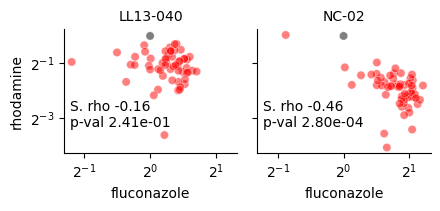

In [82]:
fig = sns.relplot(data=widerhom37_df, col='strain', col_order = ['LL13-040', 'NC-02'],
                  x='Fluco_high', y='perc_norm',
                  hue='respiration', hue_order=[True, False], palette=['black','red'], alpha=.5,
                  legend=False,
                  height=2.21, aspect=1.02 # height*aspect = width of EACH facet
                 )
plt.xscale('log', base=2)
plt.yscale('log', base=2)
fig.set_axis_labels('fluconazole', 'rhodamine')
fig.set_titles(col_template='{col_name}')

d = {'LL13-040':['S. rho', round(rhoL,2), 'p-val', pvalL], 'NC-02':['S. rho', round(rhoN,2), 'p-val', pvalN]}
for i, s in enumerate(d.keys()):
    fig.axes[0][i].text(0.43, 0.1, f'{d[s][0]} {d[s][1]}\n'+
                       f'{d[s][2]} {d[s][3]:.2e}')

#fig.axes[0][0].text(1.02,1,'WT')
#fig.axes[0][1].text(1.02,1,'WT')

#handles, labels = fig.axes[0][1].get_legend_handles_labels()
#sns.move_legend(fig, bbox_to_anchor=(0.07, 0.88), loc='upper left', title=None, frameon=True, handles=handles, labels=['$\it{rho}$⁺','$\it{rho}$⁻'], markerscale=0.75, handletextpad=0.1, borderpad=0.3)

#fig.fig.subplots_adjust(top=0.92)
#fig.fig.suptitle('Rhodamine accumulation and resistance to fluconazole of rho- mutants')
fig.tight_layout()
plt.savefig(graph_outpath+'20230413_2D_fluco_rhodamine_combined.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'20230413_2D_fluco_rhodamine_combined.png', format='png', dpi=300)

#### Relative % rhodamine accumulation vs 5-FC

In [83]:
rhoL, pvalL = get_Spearman(widerhom37_df, 'LL13-040', False, '5-FC', 'perc_norm')
rhoN, pvalN = get_Spearman(widerhom37_df, 'NC-02', False, '5-FC', 'perc_norm')

print('---LL13-040---')
print('rho = {}, p-value = {}'.format(rhoL, pvalL))
print('---NC-02---')
print('rho = {}, p-value = {}'.format(rhoN, pvalN))

---LL13-040---
rho = 0.18584298684472383, p-value = 0.17027063422224734
---NC-02---
rho = 0.08263766668345386, p-value = 0.5411167494669101


In [16]:
# Old version
rhoL, pvalL = get_Spearman(widerhom37_df, 'LL13-040', False, '5-FC', 'perc_norm')
rhoN, pvalN = get_Spearman(widerhom37_df, 'NC-02', False, '5-FC', 'perc_norm')

print('---LL13-040---')
print('rho = {}, p-value = {}'.format(rhoL, pvalL))
print('---NC-02---')
print('rho = {}, p-value = {}'.format(rhoN, pvalN))

---LL13-040---
rho = 0.12741663207694737, p-value = 0.3493684548834671
---NC-02---
rho = 0.27650712402635463, p-value = 0.037331708754831966


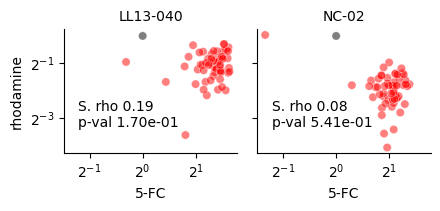

In [84]:
fig = sns.relplot(data=widerhom37_df, col='strain', col_order = ['LL13-040', 'NC-02'],
                  x='5-FC', y='perc_norm',
                  hue='respiration', hue_order=[True, False], palette=['black','red'], alpha=.5,
                  legend=False,
                  height=2.21, aspect=1.02 # height*aspect = width of EACH facet
                 )
plt.xscale('log', base=2)
plt.yscale('log', base=2)
fig.set_axis_labels('5-FC', 'rhodamine')
fig.set_titles(col_template='{col_name}')

d = {'LL13-040':['S. rho', round(rhoL,2), 'p-val', pvalL], 'NC-02':['S. rho', round(rhoN,2), 'p-val', pvalN]}
for i, s in enumerate(d.keys()):
    fig.axes[0][i].text(0.43, 0.1, f'{d[s][0]} {d[s][1]}\n'+
                       f'{d[s][2]} {d[s][3]:.2e}')

#fig.axes[0][0].text(1.02,1,'WT')
#fig.axes[0][1].text(1.02,1,'WT')

#handles, labels = fig.axes[0][1].get_legend_handles_labels()
#sns.move_legend(fig, bbox_to_anchor=(0.07, 0.88), loc='upper left', title=None, frameon=True, handles=handles, labels=['$\it{rho}$⁺','$\it{rho}$⁻'], markerscale=0.75, handletextpad=0.1, borderpad=0.3)

#fig.fig.subplots_adjust(top=0.92)
#fig.fig.suptitle('Rhodamine accumulation and resistance to fluconazole of rho- mutants')
fig.tight_layout()
plt.savefig(graph_outpath+'20230413_2D_5FC_rhodamine_combined.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'20230413_2D_5FC_rhodamine_combined.png', format='png', dpi=300)

## Scatterplots 30°C

### Two-way ANOVA with Tukey's multiple comparison test

In [91]:
from flucytosine_functions import get_Tukey
get_Tukey(sel30_df[(sel30_df.genotype.isin(['wt','mutant'])) & (sel30_df.strain=='LL13-040')], 'respiration','condition','rel_fit')[1]

C:\Users\duran\OneDrive - Université Laval\Notebooks\ASUS_notebooks\flucytosine_functions.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anova_df['combination'] = anova_df.apply(lambda row: str(row[factor1])+' / '+str(row[factor2]), axis=1)


,condition1,group1,group2,p-adj,reject,stat_significance
3,5-FC,False / 5-FC,True / 5-FC,0.2904,False,ns
10,5-FU,False / 5-FU,True / 5-FU,0.2880,False,ns
16,SD,False / SD,True / SD,0.0000,True,****
21,YPD,False / YPD,True / YPD,0.0000,True,****


C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
C:\Users\duran\OneDrive - Université Laval\Notebooks\ASUS_notebooks\Durand_et_al_2023\flucytosine_functions.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anova_df['combination'] = anova_df.apply(lambda row: str(row[factor1])+' / '+str(row[factor2]), axis=1)

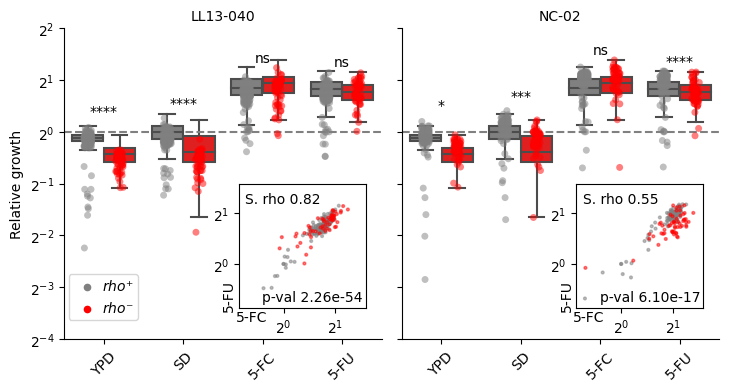

In [27]:
from scipy import stats
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig = sns.catplot(data=sel30_df[sel30_df.genotype.isin(['wt','mutant'])], x='condition', y='rel_fit',
                  col='strain', col_order=['LL13-040','NC-02'],
                  hue='respiration', hue_order=[True, False], palette=['grey','red'], alpha=.5,
                  kind='strip', dodge=True, legend_out=False,
                  height=4.02, aspect=0.93 # height*aspect = width of EACH facet
                 )

fig.map(sns.boxplot,
        data=sel30_df[sel30_df.genotype.isin(['wt','mutant'])],
        x='condition', y='rel_fit',
        hue='respiration', hue_order=[True, False], palette=['grey','red'],
        fliersize=0
       )

fig.map(plt.axhline, y=1, ls='--', c='grey')
plt.yscale('log',base=2)
fig.set(ylim=(2**-4,2**2))
fig.set_xticklabels(['YPD','SD','5-FC','5-FU'], rotation=45)
fig.set_axis_labels('', 'Relative growth')
fig.set_titles(col_template='{col_name}')

handles, labels = fig.axes[0][1].get_legend_handles_labels()
sns.move_legend(fig, bbox_to_anchor=(0.08, 0.32), loc='upper left', title=None, frameon=True, handles=handles, labels=['$\it{rho}$⁺','$\it{rho}$⁻'], markerscale=0.75, handletextpad=0.1, borderpad=0.3)

for i, s in enumerate(wide30_df.strain.unique()):
    for j, x in enumerate(sel30_df.condition.unique()):
        maxv = sel30_df[(sel30_df.genotype.isin(['wt','mutant'])) & (sel30_df.strain==s) & (sel30_df.condition==x)].rel_fit.max()
        tukey_df = get_Tukey(sel30_df[(sel30_df.genotype.isin(['wt','mutant'])) & (sel30_df.strain==s)], 'respiration','condition','rel_fit')[1]
        tukey_stat = tukey_df.loc[tukey_df.condition1==x, 'stat_significance'].values[0]
        fig.axes[0][i].text(j, maxv+0.2, tukey_stat, ha='center')
    
    FU = wide30_df[(wide30_df.strain==s) & (wide30_df.genotype.isin(['wt','mutant']))]['5-FU'].values
    FC = wide30_df[(wide30_df.strain==s) & (wide30_df.genotype.isin(['wt','mutant']))]['5-FC'].values
    rho, pval = stats.spearmanr(FU,FC)
    
    ins = inset_axes(fig.axes[0][i], "100%", "100%",
                   bbox_to_anchor=(.55, .1, .4, .4), # Coordinates of inset in units relative to axes of full panel - left bottom width height
                   bbox_transform=fig.axes[0][i].transAxes,
                   borderpad=0)
    ins.scatter(FC, FU, c=wide30_df[(wide30_df.strain==s) & (wide30_df.genotype.isin(['wt','mutant']))]['respiration'].map({True:'grey', False:'red'}), alpha=.5, s=4)
    plt.xscale('log',base=2)
    plt.yscale('log',base=2)
    ins.set(xlim=(0.55,3), ylim=(0.55,3))
    ins.set_xlabel('5-FC')
    ins.xaxis.set_label_coords(.1, -.02)
    ins.set_ylabel('5-FU')
    ins.yaxis.set_label_coords(-.02, .1)
    ins.text(0.6,2.3, f'S. rho {round(rho,2)}')
    ins.text(0.75,0.6, f'p-val {pval:.2e}')

#fig.fig.subplots_adjust(top=0.92)
#fig.fig.suptitle('Relative fitness at 30°C')
fig.tight_layout()
plt.savefig(graph_outpath+'20230724_rel_fit_pooled_respi_30_22h_stats.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'20230724_rel_fit_pooled_respi_30_22h_stats.png', format='png', dpi=300)

In [45]:
sel30_df[(sel30_df.genotype == 'wt') & (sel30_df.strain == 'NC-02')]

,plate_number,RA_well,auc,rearray_plate_nb,condition,mutant_plate,96_well,strain,fluc_assay,pre_culture,fluc_mutant,genotype,FCY1_genotype,FUR1_genotype,respiration,key,Genomix_plate_nb,Genomix_plate_well,rel_fit
400,1,E23,14764.750,1,YPD,3,E12,NC-02,NaN,NaN,NaN,wt,NaN,NaN,True,298,3.0,B12,1.0
401,2,E23,10704.500,1,SD,3,E12,NC-02,NaN,NaN,NaN,wt,NaN,NaN,True,298,3.0,B12,1.0
402,3,E23,6496.875,1,5-FC,3,E12,NC-02,NaN,NaN,NaN,wt,NaN,NaN,True,298,3.0,B12,1.0
403,4,E23,5012.375,1,5-FU,3,E12,NC-02,NaN,NaN,NaN,wt,NaN,NaN,True,298,3.0,B12,1.0
440,5,G11,16358.625,3,YPD,3,E12,NC-02,NaN,NaN,NaN,wt,NaN,NaN,True,60,NaN,NaN,1.0
441,6,G11,9776.375,3,SD,3,E12,NC-02,NaN,NaN,NaN,wt,NaN,NaN,True,60,NaN,NaN,1.0
442,7,G11,3667.750,3,5-FC,3,E12,NC-02,NaN,NaN,NaN,wt,NaN,NaN,True,60,NaN,NaN,1.0
443,8,G11,4629.375,3,5-FU,3,E12,NC-02,NaN,NaN,NaN,wt,NaN,NaN,True,60,NaN,NaN,1.0


C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


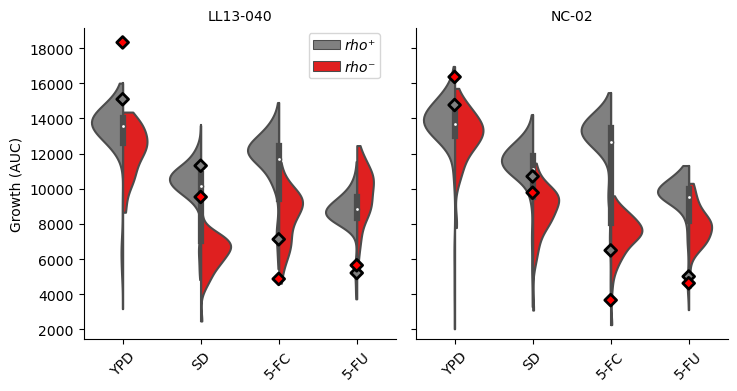

In [74]:
fig = sns.catplot(data=sel30_df[sel30_df.genotype == 'mutant'], x='condition', y='auc',
                  col='strain', col_order=['LL13-040','NC-02'],
                  hue='respiration', hue_order=[True, False], palette=['grey','red'], alpha=.5,
                  kind='violin', cut=0, split=True, legend_out=False,
                  height=4.02, aspect=0.93 # height*aspect = width of EACH facet
                 )

cdic = {1: 'grey', 2: 'red', 3: 'red'}
for i, s in enumerate(sel30_df.strain.unique()):
    fig.axes[0][i].scatter(data=sel30_df[(sel30_df.genotype == 'wt') & (sel30_df.strain == s)],
                           x='condition', y='auc',
                           c=sel30_df[(sel30_df.genotype == 'wt') & (sel30_df.strain == s)].rearray_plate_nb.map(cdic),
                           marker='D', zorder=1000, edgecolor='black', linewidth=2
                          )

fig.set(xlim=(-0.5, len(sel30_df.condition.unique())-0.5))
fig.set_xticklabels(['YPD','SD','5-FC','5-FU'], rotation=45)
fig.set_axis_labels('', 'Growth (AUC)')
fig.set_titles(col_template='{col_name}')

handles, labels = fig.axes[0][1].get_legend_handles_labels()
sns.move_legend(fig, bbox_to_anchor=(0.41, 0.92), loc='upper left', title=None, frameon=True,
                handles=handles, labels=['$\it{rho}$⁺','$\it{rho}$⁻'],
                markerscale=0.75, handletextpad=0.25, borderpad=0.3)

fig.tight_layout()
plt.savefig(graph_outpath+'20230425_AUC_pooled_respi_30_22h_stats.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'20220425_AUC_pooled_respi_30_22h_stats.png', format='png', dpi=300)

C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


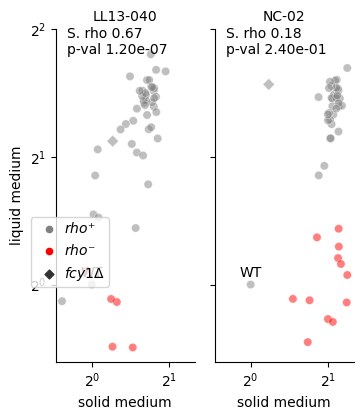

In [28]:
from scipy import stats
strains = ['LL13-040','NC-02']
fig = sns.relplot(data=wide_sol_liq,
                  x='5-FC', y='5-FC_liq',
                  col='strain', col_order=strains,
                  hue='respiration', hue_order=[True,False], palette=['grey','red'], alpha=.5,
                  style='genotype', markers=['o','o','D'],
                  height=4.3, aspect=0.44 # height*aspect = width of EACH facet
                 )
plt.xscale('log', base=2)
plt.yscale('log', base=2)
fig.set(ylim=(None,2**2))
fig.set_axis_labels('solid medium', 'liquid medium')
fig.set_titles(col_template='{col_name}')

for i, s in enumerate(strains): # for each panel (1 per strain)
    # Label WT
    fig.axes[0][i].text(1,1.04,'WT',horizontalalignment='center')
    
    # Get Spearman correlation coefficient
    sol = wide_sol_liq[wide_sol_liq.strain == s]['5-FC'].values
    liq = wide_sol_liq[wide_sol_liq.strain == s]['5-FC_liq'].values
    rho, pval = stats.spearmanr(sol,liq)
    fig.axes[0][i].text(.8,3.5,f'S. rho {round(rho,2)}\np-val {pval:.2e}',horizontalalignment='left')

handles, labels = fig.axes[0][0].get_legend_handles_labels()
new_handles = [handles[1], handles[2], handles[6]]
sns.move_legend(fig, bbox_to_anchor=(0.06, 0.5), loc='upper left', title=None, frameon=True,
                handles=new_handles, labels=['$\it{rho}$⁺','$\it{rho}$⁻',u'$\it{fcy1}$Δ'],
                markerscale=0.75, handletextpad=0.1, borderpad=0.3)

#fig.fig.subplots_adjust(top=0.92)
#fig.fig.suptitle('Relative fitness in liquid vs solid medium + 5-FC')
fig.tight_layout()
plt.savefig(graph_outpath+'/20230914_2D_5-FC_sol_liq.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'/20230914_2D_5-FC_sol_liq.png', format='png', dpi=300)

## Scatterplots YPG

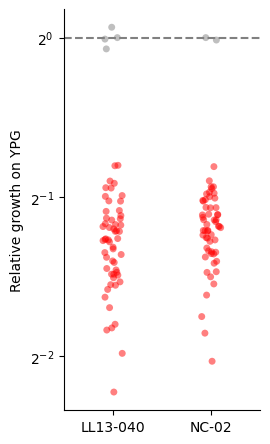

In [15]:
f, ax = plt.subplots(figsize=(2.8, 4.55))
fig = sns.stripplot(data=rhomYPG, x='strain', y='rel_fit',
                    hue='respiration', hue_order=[True,False], palette=['grey','red'], alpha=.5,
                    legend=None
                   )
plt.axhline(y=1, ls='--', c='grey')
plt.yscale('log', base=2)
fig.axes.set(xlabel='', ylabel='Relative growth on YPG')
sns.despine()
plt.tight_layout()
plt.savefig(graph_outpath+'/20230419_YPG.svg', format='svg', dpi=300)
plt.savefig(graph_outpath+'/20230419_YPG.png', format='png', dpi=300)